> That is, when can we afford a house?

# Motivation

The house price and income in Bay Area are both relatively higher than other regions in the U.S. because of the prospering technology companies. We are interested in the geo-distribution of the house price and income, and  calculate the approximate time needed to afford a house based on the house location and the income. 

# Introduction

We will have following sections:

0. Zipcode and Shape Data
    - We will first retrieve ZIP codes around Bay Area and shape data for later plotting.
1. Income Data
    - The income data is obtained from the U.S. Department of Commerce at https://www.census.gov/topics/income-poverty/income/data/tables.html
2. House Price Data
    - The house price data is obtained from Zillow at https://www.zillow.com/research/data/
3. Income v.s. House Price
    - After combining these two datasets, we will plot onto the map and analyze the time needed to afford a house based on different choice of house locations. 

# Setup

Run following command in your terminal:

    $ pip install -r requirements.txt

# Zipcode and Shape Data

## Retrieve Zip Code List

We will use ZIP code as the key to search house price and income of an area. First, we need to retrieve the ZIP codes around Bay Area.  

In [2]:
import os
import json
import ntpath
import wget

In [3]:
"""
Reference: https://catalog.data.gov/dataset/bay-area-zip-codes
"""
def get_bay_area_zipcode():
    
    url = "https://data.sfgov.org/api/views/f9wk-m4qb/rows.json?accessType=DOWNLOAD"
    filename = "rows.json"

    # Remove previous downloaded csv file if exists
    try:
        os.remove(ntpath.basename(filename))
    except OSError:
        pass
    
    filename = wget.download(url)
    with open(filename) as f:
        raw_data = json.load(f)
        zipcode_list = [row[10] for row in raw_data["data"]]
    return zipcode_list

In [4]:
zipcode_list = get_bay_area_zipcode()
print(len(zipcode_list))
print(zipcode_list)

187
['94558', '94533', '95620', '95476', '94559', '94954', '94571', '94535', '94503', '94949', '94945', '94512', '94591', '94510', '94592', '94589', '94947', '94590', '94946', '94561', '94525', '94569', '94585', '94103', '94565', '94903', '94520', '94572', '94553', '94547', '94963', '94938', '94502', '94509', '94960', '94513', '94109', '94521', '94930', '94973', '94933', '94598', '94564', '94801', '94519', '94806', '94901', '94531', '94803', '94601', '94523', '94518', '94904', '94115', '94549', '94517', '94805', '94804', '94939', '94964', '94530', '94925', '94596', '94708', '94105', '94941', '94563', '94720', '94707', '94514', '94970', '94706', '94710', '94104', '94595', '94709', '94703', '94704', '94507', '94702', '94965', '94556', '94920', '94118', '94705', '94611', '94618', '94609', '94550', '94608', '94528', '94526', '94506', '94130', '94607', '94123', '94610', '94583', '94602', '94612', '94546', '94133', '94129', '94606', '94111', '94619', '94121', '94102', '94552', '94501', '9410

## Retrieve Shape Data

In order to plot the geographic distribution using ZIP codes, we will need the cartographic boundary data. 

In [5]:
import os
import zipfile
import shutil
import shapefile

In [6]:
"""
Source: https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html
"""
def download_zipcode_shapefile():
    
    url = "http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_zcta510_500k.zip"
    output = "./data/"
    target = "./data/cb_2016_us_zcta510_500k.shp"
    
    # Remove previous extracted folder if exists
    try:
        shutil.rmtree(output)
    except OSError:
        pass
    
    # Remove previous downloaded zip file if exists
    try:
        os.remove(ntpath.basename(url))
    except OSError:
        pass
    
    # Download and extract
    zip_data = wget.download(url)
    with zipfile.ZipFile(zip_data) as zip_ref:
        zip_ref.extractall(output)
        
    return target

In [7]:
raw_data = download_zipcode_shapefile()
shape_records = shapefile.Reader(raw_data).shapeRecords()

In [8]:
# filter_shape_record: Only keep the records that have a match in our ZIP code list.
def filter_shape_record(shape_records, zipcode_list):
    filtered = []
    for sr in shape_records:
        if sr.record[0] in zipcode_list:
            filtered.append(sr)
    return filtered

In [9]:
filtered_shape_records = filter_shape_record(shape_records, zipcode_list)
print(len(filtered_shape_records), len(zipcode_list))

186 187


# Income

## Retrieve Income Data



In [10]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [11]:
"""
Source: https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml
Example: https://factfinder.census.gov/rest/communityFactsNav/nav?spotlightId=INCOME&searchTerm=94041
"""
def get_avg_income_by_zipcode(zipcode):
    url = "https://factfinder.census.gov/rest/communityFactsNav/nav?spotlightId=INCOME&searchTerm=" + str(zipcode)
    req = requests.get(url=url)
    html = req.json()["CFMetaData"]["measureAndLinksContent"]
    dom = BeautifulSoup(html, "lxml")
    try:
        income = re.sub('[^0-9]','', dom.findAll("div", {"class": "value"})[0].text)
    except Exception:
        print("No value found for zipcode %s" % zipcode)
        return None
    print(zipcode, income)
    return income

In [12]:
# Test
zipcode = 94558
avg_income = get_avg_income_by_zipcode(zipcode)

94558 77299


In [13]:
def get_income(zipcode_list):
    m = {}
    for zipcode in zipcode_list:
        income = get_avg_income_by_zipcode(zipcode)
        if income:
            m[zipcode] = int(income)
    income = pd.DataFrame.from_dict(m, orient = "index")
    income.columns = ["income"]
    income.sort_values(by=["income"], inplace=True, ascending=False)
    return income

In [14]:
income = get_income(zipcode_list)

94558 77299
94533 57316
95620 72583
95476 68894
94559 65891
94954 83713
94571 54852
94535 54692
94503 83627
94949 78568
94945 90685
No value found for zipcode 94512
94591 73897
94510 87569
94592 110648
94589 57316
94947 88119
94590 41530
94946 108750
94561 81910
94525 78750
94569 136875
94585 70491
94103 46140
94565 60020
94903 92552
94520 51096
94572 70227
94553 84638
94547 102993
94963 91806
94938 103854
94502 115765
94509 55022
94960 112045
94513 93951
94109 71043
94521 88339
94930 99338
94973 90824
94933 76393
94598 125089
94564 73861
94801 43393
94519 74351
94806 52698
94901 82231
94531 90126
94803 78759
94601 41918
94523 94042
94518 78301
94904 111845
94115 97090
94549 147368
94517 128398
94805 72009
94804 51276
94939 99844
94964 107167
94530 91052
94925 125915
94596 82869
94708 147837
94105 195165
94941 131703
94563 174526
No value found for zipcode 94720
94707 140711
94514 54348
94970 109412
94706 86043
94710 63080
94104 51500
94595 62374
94709 63701
94703 68842
94704 26173
945

In [15]:
# zipcodes with top high income
income.head()

,income
94027,243542
94028,229554
94024,204534
94105,195165
94022,194014


## Plot

In [16]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as cmx

In [17]:
def get_normalized_df(df):
    return (df - df.min()) / (df.max() - df.min())

In [18]:
normalized_df = get_normalized_df(income)
print(normalized_df.get_value("94558", "income"))

0.23520373190289323


In [19]:
"""
Reference: https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
"""
def plot_shapes(shape_records, record2value, column_name):
    plt.clf()
    plt.figure()
    for sr in shape_records:
        index = sr.record[0]
        try:
            val = record2value.get_value(index, column_name)
        except KeyError:
            continue
        x = [i[0] for i in sr.shape.points[:]]
        y = [i[1] for i in sr.shape.points[:]]
        plt.fill(x, y, get_heapmap_color_hex(val))
    plt.show()
    plt.close()

In [20]:
"""
Jet colormap: https://www.mathworks.com/help/matlab/ref/jet.html
"""
def get_heapmap_color_hex(val):
    r, g, b = plt.cm.jet(val)[:3]
    return "#%02x%02x%02x" % (int(r * 255), int(g * 255), int(b * 255))

In [21]:
print(get_heapmap_color_hex(0.5))
print(get_heapmap_color_hex(1.0))

#7cff79
#7f0000


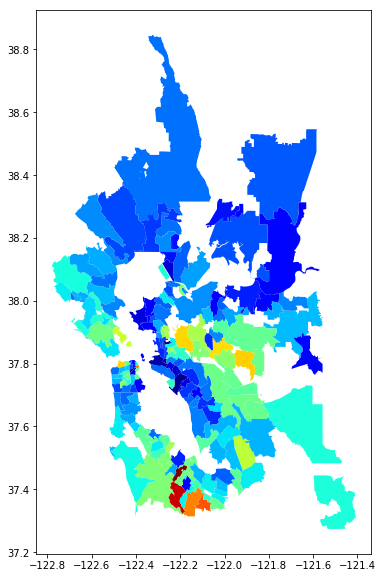

In [22]:
plt.rcParams["figure.figsize"] = [6, 10] # Size: [width, height]
plot_shapes(filtered_shape_records, normalized_df, "income")

# House Price Data

## Retrieve House Price Data

The house price data is downloaded from [Zillow](https://www.zillow.com/research/data/), that has the house price from 1996 to 2018. For this project, we will use the most recent house price.

In [23]:
def load_data(file_name):
    
    df = pd.read_csv(file_name, na_filter=False)
        
    # drop instance with missing values
    df = df.replace("", pd.np.nan).dropna(how='any')
    
    # convert values to int data type
    y = "1996"
    m = "04"
    date = y + "-" + m
    while date != "2018-02":        
        df[date] = df[date].apply(pd.to_numeric)       
        if m == "12":
            m = "01"
            y = str(int(y)+1)
        else:
            m = int(m)+1
            if m < 10:
                m = "0"+str(m)
            else:
                m = str(m)       
        date = y + "-" + m
    
    # convert zipcode to string data type
    df['RegionName'] = df['RegionName'].apply(str)
    
    # set zipcode as index
    df.set_index('RegionName', inplace=True)
    return df

houses = load_data("homes_CA.csv")

In [24]:
houses.head()

,﻿RegionID,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02
RegionName,,,,,,,,,,,,,,,,,,,,,
93306,97222,Bakersfield,CA,Bakersfield,Kern,333,86800,87100,87500,88200,...,186300,186300,186500,187000,187700,188500,189400,190600,192100,193700
93307,97223,Bakersfield,CA,Bakersfield,Kern,343,67000,66800,67100,67800,...,159100,159600,159400,159200,159900,160300,160800,161500,162600,164000
93309,97225,Bakersfield,CA,Bakersfield,Kern,348,89000,89200,89100,88700,...,188300,189300,189700,190300,191200,191900,192000,192200,193200,194500
93308,97224,Oildale,CA,Bakersfield,Kern,587,82700,83500,84000,84700,...,190000,190500,191000,191100,191000,191100,191700,191800,192600,194100
93312,97227,Bakersfield,CA,Bakersfield,Kern,747,132400,132300,132300,131900,...,272500,272700,272500,272900,273800,274700,275600,276600,277900,279600


## Get the Most Recent House Price

In [25]:
def get_most_recent_houseprice(df):
    house_price = df[["2018-02"]].copy()
    house_price.rename(columns={"2018-02": "price"}, inplace=True)
    return house_price

most_recent_houseprice = get_most_recent_houseprice(houses)   

In [26]:
most_recent_houseprice.head()

,price
RegionName,
93306,193700
93307,164000
93309,194500
93308,194100
93312,279600


In [27]:
# zipcodes with top low house price

most_recent_houseprice.sort_values(by=['price'], inplace=True)
most_recent_houseprice.head()

,price
RegionName,
93501,101100
92365,117200
92277,123700
93241,124600
93268,127000


## Retrieve Shape Data

We reuse the shapa data from the first section.

## Plot

In [28]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as cmx

In [29]:
normalized_df = get_normalized_df(most_recent_houseprice)
print(normalized_df.get_value("94558", "price"))

0.0987472787686667


In [30]:
plt.rcParams["figure.figsize"] = [6, 10] # Size: [width, height]

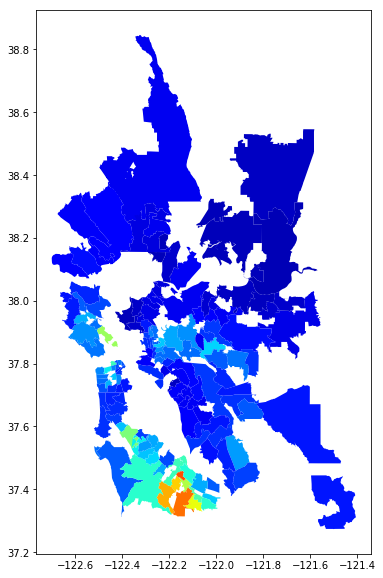

In [31]:
plot_shapes(filtered_shape_records, normalized_df, "price")

# Income v.s. House Price


Now we already have the income and house price data, we can analyze the approximate time that is needed to buy a house. A choice of the house location is using ZIP code, as same as how our data is represented. To simply the problem, here we only consider the house price without interest, and assume that we are paying at once, so that the house price is constant. The first method of estimation is to compute the ratio of the average house price to the average of income per area. The result will be the number of years neeeded to pay for a house in a specific area with the average income of that specific area. 

To get the result, first we need to merge the two datasets, and compute the years needed according to the method mentioned above. 


In [32]:
# Merge house price and income table
income_vs_price = pd.merge(income, most_recent_houseprice,
                           how="inner",left_index=True, right_index=True)
income_vs_price["years_needed"] = income_vs_price["price"] / income_vs_price["income"]
income_vs_price = income_vs_price.sort_values("years_needed")
income_vs_price.head()

,income,price,years_needed
94531,90126,479100,5.315891
94585,70491,383700,5.443248
94561,81910,455300,5.558540
94105,195165,1125900,5.768965
95620,72583,423400,5.833322


In [33]:
print(income_vs_price.loc["94040"]["price"], income_vs_price.loc["94040"]["income"])

2414300.0 115600.0


## Living in the same zipcode

To understand the geographic distribution of the estimated years needed, we can plot our result onto the map. Note that the number of years needed to afford a house is based on the same area, with the same ZIP code, as your working location.

To plot the result, we need to normalize the data as we did before.

In [34]:
normalized_df = get_normalized_df(income_vs_price)
normalized_df.head()

,income,price,years_needed
94531,0.314449,0.030418,0.000000
94585,0.217906,0.007016,0.001979
94561,0.274052,0.024579,0.003770
94105,0.830913,0.189079,0.007040
95620,0.228192,0.016754,0.008040


In [41]:
# Sort the values based on number of years needed
sorted_df = normalized_df.sort_values(['years_needed'], ascending = False)
sorted_df.head()

,income,price,years_needed
94305,0.132756,0.821641,1.000000
94704,0.000000,0.223569,0.669316
94301,0.537189,1.000000,0.425889
94102,0.016142,0.129618,0.383468
94306,0.457191,0.663175,0.316259


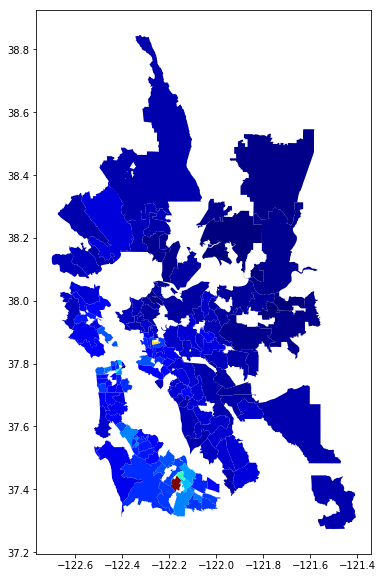

In [35]:
plot_shapes(filtered_shape_records, normalized_df, "years_needed")

From the plot we can see that the result is centered at the lower left corner of the map, the other regions have relatively low house price and income ratio. The highest ratio happens at ZIP code 94305, where it is near Stanford and Palo Alto. There are some interesting facts about this area that can be found at http://www.city-data.com/zips/94305.html. For example, compared to state average, the house price is significantly higher, but the house age is below state average, and the number of college students issignificantly above state average.


## Living close to where you work

The above method of helping you make a choice on housing location is not useful enough, since it limits the house location and the work location to be the same. In addition, the result shows that the region outside the red spot on the map has significantly lower value than the red spot area, making the distribution difficult to have insightful analysis. Therefore, we can analyze the result based in two different ways that either fix work location or fix house location.

The first method assumes the work location to be fixed, so we can choose houses in different location that the distance between the house and the work location lies in certain range. We set the range to be 10 miles, which is the maximum miles you would want to commute everyday to work. Given this range of distance, we can extract the neighbor ZIP codes that lie within this distance. We use the center of a certain area to calculate the distance between different zones. 

First we need to get the list of the neighbor zipcode which is close enough for daily commute.

In [1]:
import geopy.distance
from statistics import median

ModuleNotFoundError: No module named 'geopy'

In [38]:
def get_shape_center(shape):
    lats = [point[0] for point in shape.points]
    lngs = [point[1] for point in shape.points]
    return median(lats), median(lngs)

In [39]:
print(get_shape_center(filtered_shape_records[0].shape))

(-121.603149, 37.37496)


In [40]:
THRESHOLD_MILES = 10 # Maximum miles you want to commute every workday
def get_neighbor_list(shape_records):
    
    # Builds zipcode -> center map
    zipcode_center = {}
    for rs in shape_records:
        zipcode = rs.record[0]
        zipcode_center[zipcode] = get_shape_center(rs.shape)
    
    # Builds neighbor list
    neighbor_list = {}
    for rs in shape_records:
        zipcode = rs.record[0]
        center = zipcode_center[zipcode]
        neighbor_list[zipcode] = [
            neighbor for neighbor in zipcode_center.keys()
            if geopy.distance.vincenty(zipcode_center[neighbor], center).miles <= THRESHOLD_MILES
        ]
    
    return neighbor_list

In [41]:
neighbor_dic = get_neighbor_list(filtered_shape_records)
neighbor_dic["94040"]

['94085',
 '94089',
 '94027',
 '94305',
 '94560',
 '94086',
 '94028',
 '94544',
 '94306',
 '94024',
 '94022',
 '94025',
 '94538',
 '94043',
 '94301',
 '94545',
 '94303',
 '94040',
 '94555',
 '94087',
 '95002',
 '94304',
 '94587']

Now we have lists of neighbors for a ZIP code, let's use the minimum house price value of from the neighbors instead if it's smaller than current price.

In [42]:
def append_min_neighbor_price(df, neighbor_dic):
    income_vs_price["neighbor_min_price"] = income_vs_price["price"]
    for index, row in income_vs_price.iterrows():
        neighbors = neighbor_dic[index]
        neighbor_min_price = min([
            income_vs_price.loc[neighbor]["price"]
            for neighbor in neighbors if neighbor in income_vs_price.index
        ])
        income_vs_price.set_value(index, "neighbor_min_price", neighbor_min_price)

In [43]:
append_min_neighbor_price(income_vs_price, neighbor_dic)
income_vs_price.head()

,income,price,years_needed,neighbor_min_price
94531,90126,479100,5.315891,355100
94585,70491,383700,5.443248,371900
94561,81910,455300,5.558540,355100
94105,195165,1125900,5.768965,386400
95620,72583,423400,5.833322,423400


In [44]:
normalized_df = get_normalized_df(income_vs_price)
normalized_df.head()

,income,price,years_needed,neighbor_min_price
94531,0.314449,0.030418,0.000000,0.000000
94585,0.217906,0.007016,0.001979,0.021798
94561,0.274052,0.024579,0.003770,0.000000
94105,0.830913,0.189079,0.007040,0.040612
95620,0.228192,0.016754,0.008040,0.088621


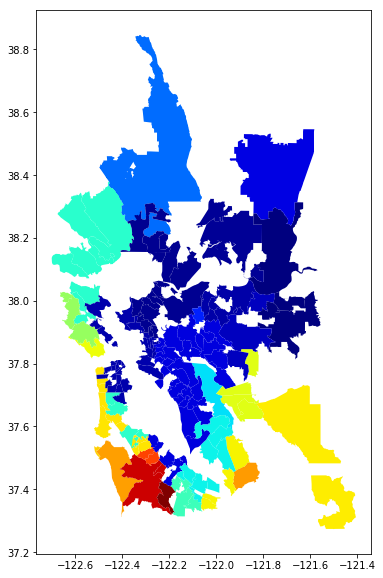

In [45]:
plot_shapes(filtered_shape_records, normalized_df, "neighbor_min_price")

Now that we are plotting the minimum house price that is within the threshold distance, compared to the one that plot the average house price of each area, this one is not as centered as the previous plot. Giving tolerance to commute within a certain distance can give you more choices that are not as extreme as the previous plot. 


We can now plot the number of years needed for the minimum house price within the neighbor. The method to calculate the number of years needed is same as above.

In [46]:
income_vs_price["years_needed_neighbor_min_price"] = income_vs_price["neighbor_min_price"] / income_vs_price["income"]
income_vs_price = income_vs_price.sort_values("years_needed_neighbor_min_price")
income_vs_price.head()

,income,price,years_needed,neighbor_min_price,years_needed_neighbor_min_price
94105,195165,1125900,5.768965,386400,1.979863
94506,175947,1365400,7.760291,397600,2.259771
94563,174526,1630100,9.340156,419200,2.401934
94507,172414,1856800,10.769427,420200,2.437157
94920,155710,2909000,18.682166,386400,2.481536


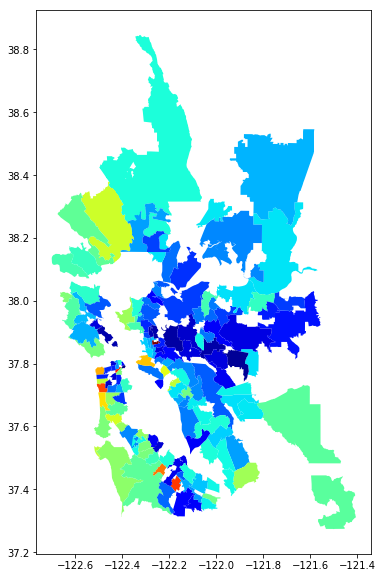

In [47]:
normalized_df = get_normalized_df(income_vs_price)
plot_shapes(filtered_shape_records, normalized_df, "years_needed_neighbor_min_price")

In [ ]:
# todo

## Working close to where you live

An alternate to analyze the time needed to buy a house is to fix the living location, and look for the work location that has the highest average income. Here we are using the same neighbor list as above, giving a threshold of 10 miles to be the maximum distance to commute every workday. For each ZIP code, walk through all the areas in its neighbor and retrieve the area with highest income, then calculate the number of years needed using that highest income.

In [48]:
def append_max_neighbor_income(df, neighbor_dic):
    df["neighbor_max_income"] = df["income"]
    for index, row in df.iterrows():
        neighbors = neighbor_dic[index]
        neighbor_max_income = max([
            df.loc[neighbor]["income"]
            for neighbor in neighbors if neighbor in df.index
        ])
        df.set_value(index, "neighbor_max_income", neighbor_max_income)

In [49]:
append_max_neighbor_income(income_vs_price, neighbor_dic)
income_vs_price.head()

,income,price,years_needed,neighbor_min_price,years_needed_neighbor_min_price,neighbor_max_income
94105,195165,1125900,5.768965,386400,1.979863,195165
94506,175947,1365400,7.760291,397600,2.259771,175947
94563,174526,1630100,9.340156,419200,2.401934,174526
94507,172414,1856800,10.769427,420200,2.437157,175947
94920,155710,2909000,18.682166,386400,2.481536,195165


In [50]:
plot_shapes(filtered_shape_records, normalized_df, "neighbor_max_income")

In [51]:
income_vs_price["years_needed_neighbor_max_income"] = income_vs_price["price"] / income_vs_price["neighbor_max_income"]
income_vs_price = income_vs_price.sort_values("years_needed_neighbor_max_income")
income_vs_price.head()

,income,price,years_needed,neighbor_min_price,years_needed_neighbor_min_price,neighbor_max_income,years_needed_neighbor_max_income
94801,43393,386400,8.904662,386400,8.904662,195165,1.979863
94509,55022,397600,7.226200,397600,7.226200,175947,2.259771
94806,52698,441500,8.377927,368400,6.990778,195165,2.262188
94804,51276,450500,8.785787,386400,7.535689,195165,2.308303
94565,60020,420200,7.001000,383700,6.392869,175947,2.388219


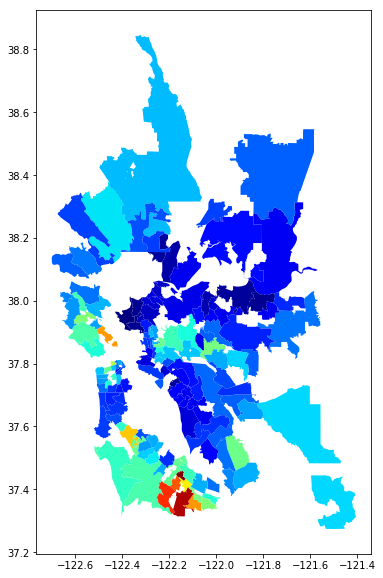

In [52]:
normalized_df = get_normalized_df(income_vs_price)
plot_shapes(filtered_shape_records, normalized_df, "years_needed_neighbor_max_income")

In [ ]:
#todo